In [1]:
import os
import pandas as pd
import quantstats as qs
import yfinance as yf
from modules.strategy import group4_ensemble_model_signals

from zipline.api import (order, order_target, record, symbol, get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
tickers = os.listdir('./CSVs/daily/')
tickers = [x.replace('.csv', '') for x in tickers]
print(len(tickers))

48


In [3]:
start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2022-12-31')

window = 100
capital_base = 100000
position = 5

In [4]:
%%capture backtest_cell_output 

def initialize(context):
    context.i = 0

    assets = list()
    for ticker in tickers:
        assets.append(symbol(ticker))
    context.assets = assets
    
    
def handle_data(context, data):
    context.i += 1
    if context.i < window + 1:
        return

    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, "price")

            curr_win_data = data.history(asset, ['open', 'high', 'low', 'close', 'volume'], bar_count=window, frequency="1d")
            signal = group4_ensemble_model_signals(curr_win_data)

            if signal == 1:
                order_target(asset, 5)
            elif signal == -1: 
                order_target(asset, 0)
            else:
                pass
    


result = run_algorithm(
    start=start_date,
    end=end_date,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    bundle='snp50',
    data_frequency='daily',
    )
                        

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-05-29   2018-05-29
End Period                 2022-12-30   2022-12-30
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          43.08%       2.51%
Mean Active Return         0.0%         -0.04%
CAGR﹪                     5.53%        0.37%

Sharpe                     0.46         0.19
Prob. Sharpe Ratio         83.65%       65.65%
Smart Sharpe               0.45         0.18
Sortino                    0.64         0.25
Smart Sortino              0.62         0.25
Sortino/√2                 0.45         0.18
Smart Sortino/√2           0.44         0.18
Omega                      1.03         1.03

Max Drawdown               -31.53%      -6.95%
Longest DD Days            361          484
Volatility (ann.)          22.42%       3.12%
R^2                        0.57         0.57
Calmar               

None

-0.030394779382404136





,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-09-03,2022-10-14,2022-12-30,484,-6.945733,-6.871815
2,2020-02-18,2020-03-23,2020-08-25,190,-3.575196,-3.397697
3,2018-09-17,2018-12-24,2020-01-10,481,-2.858136,-2.502726
4,2020-09-03,2020-09-23,2020-11-04,63,-1.739189,-1.726994
5,2021-02-17,2021-03-04,2021-04-14,57,-1.560464,-1.457238


Average Long Exposure = 15568.530381254965
Average Short Exposure = 0.0
Average Net Leverage = 0.15117369482080295
Average Gross Leverage = 0.15117369482080295
Max Leverage = 0.30754894745140066



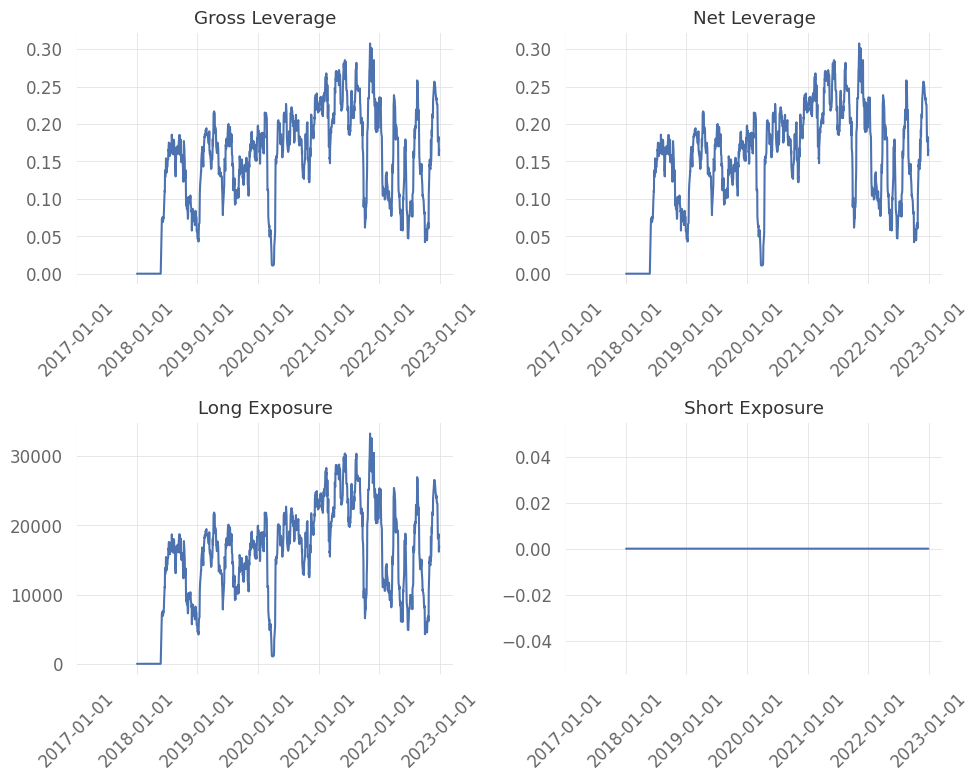

AAPL ABT ADBE AEP AES AFL ALGN AMD AMT AOS APA APD ARE AWK AXON BA BAC BAX BDX BG BKR BRK-B BX BXP CAT CCI CDNS CE COF CPB CPT DIS EA FMC GOOGL IFF KLAC LNT MMM MO NVDA STZ TECH TRGP VLO WBD WMB WMT


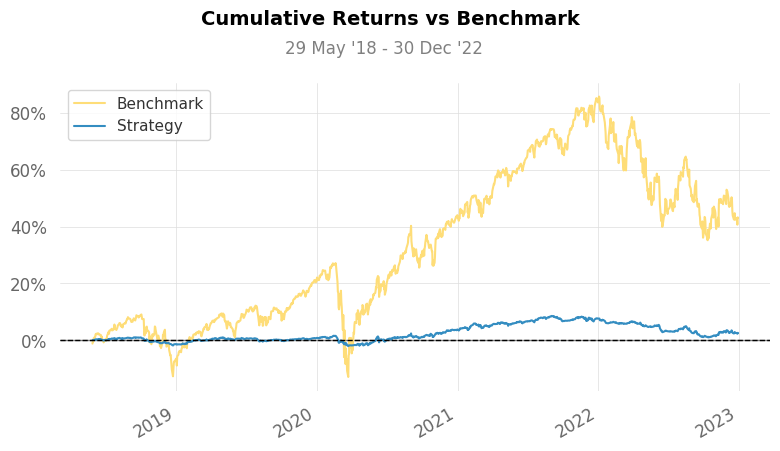

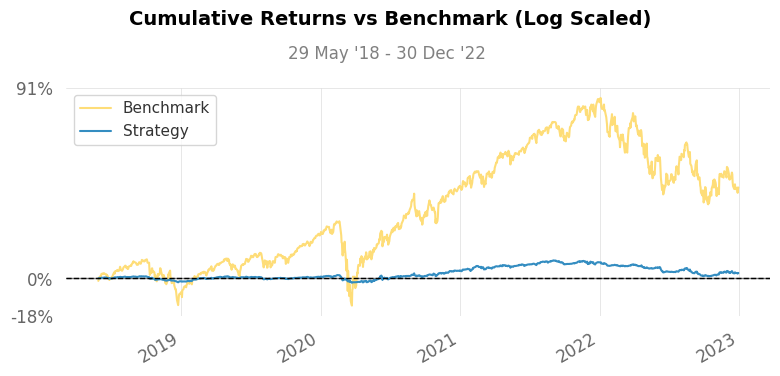

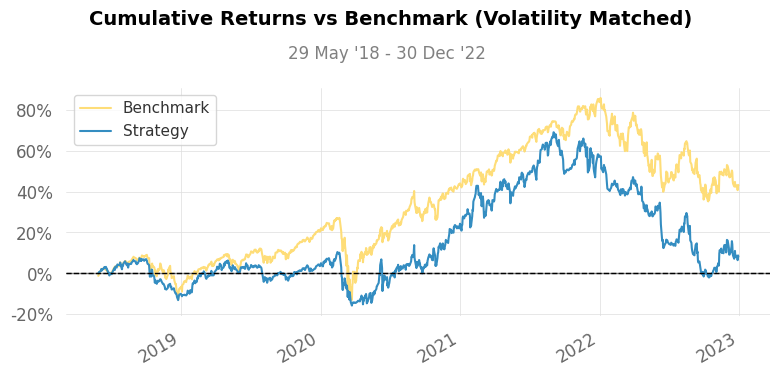

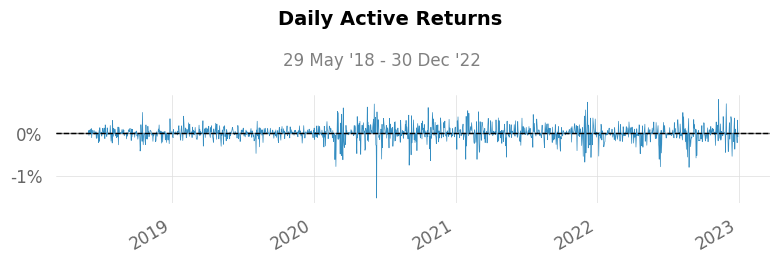

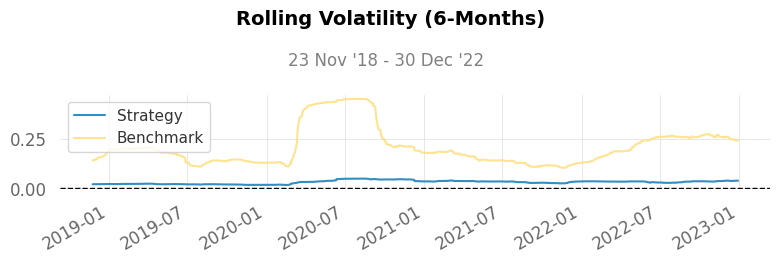

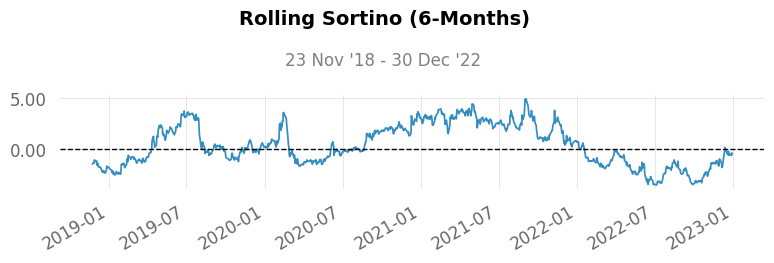

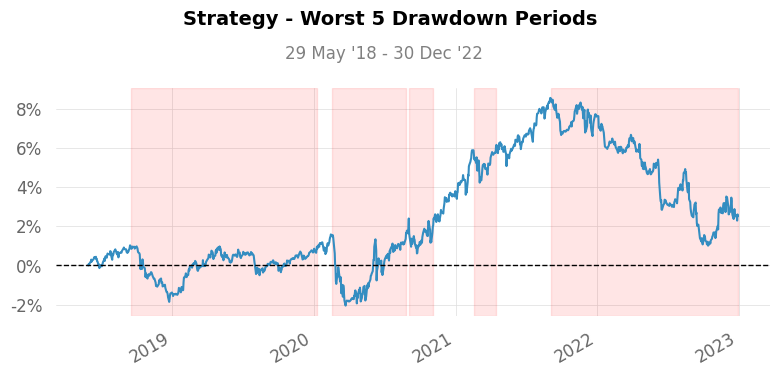

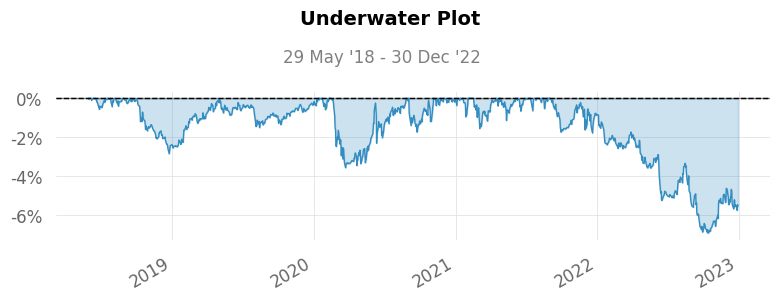

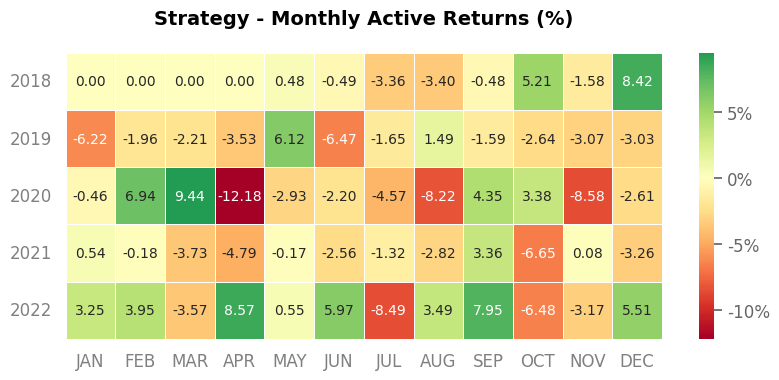

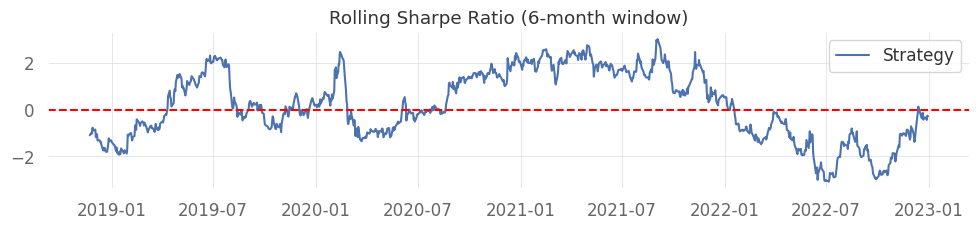

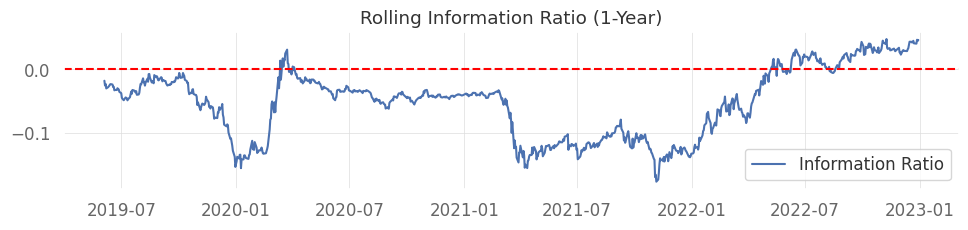

[*********************100%%**********************]  1 of 1 completed


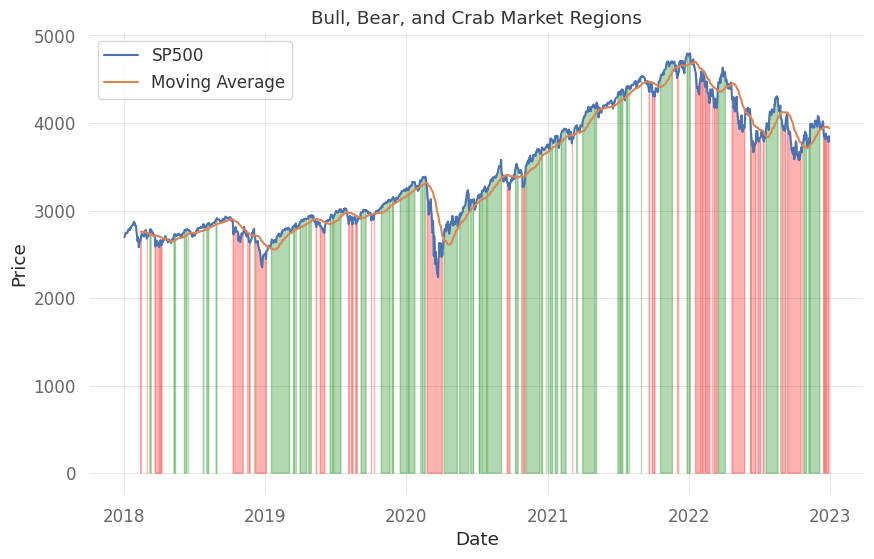

Total Trades: 2219
Daily Trades: 2
Weekly Trades: 10
Monthly Trades: 42





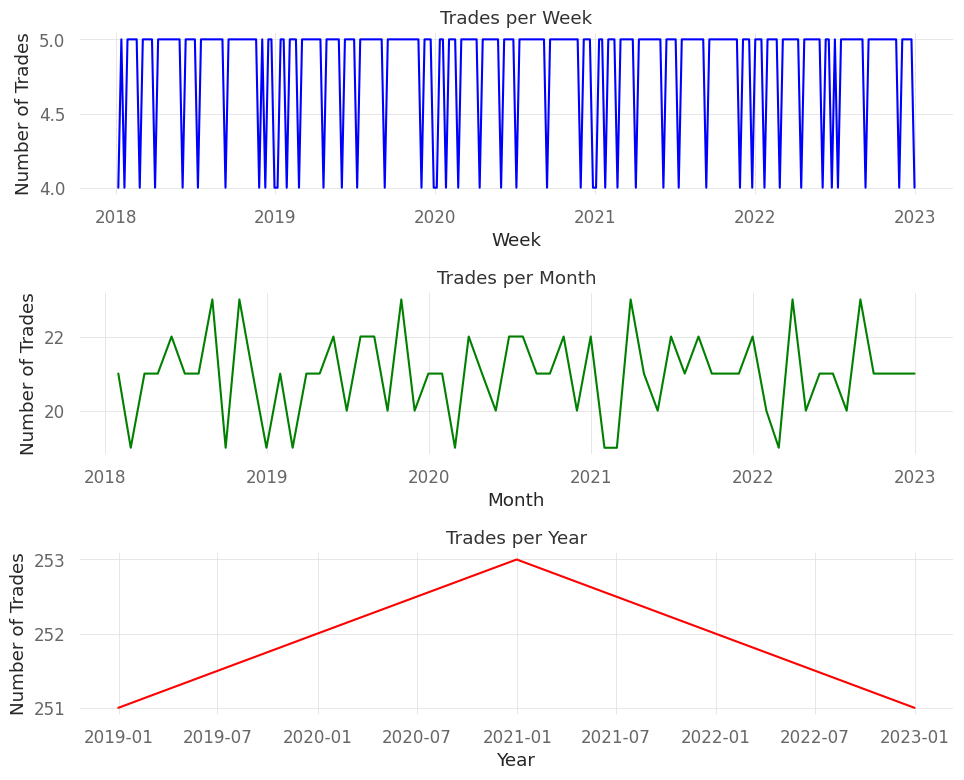

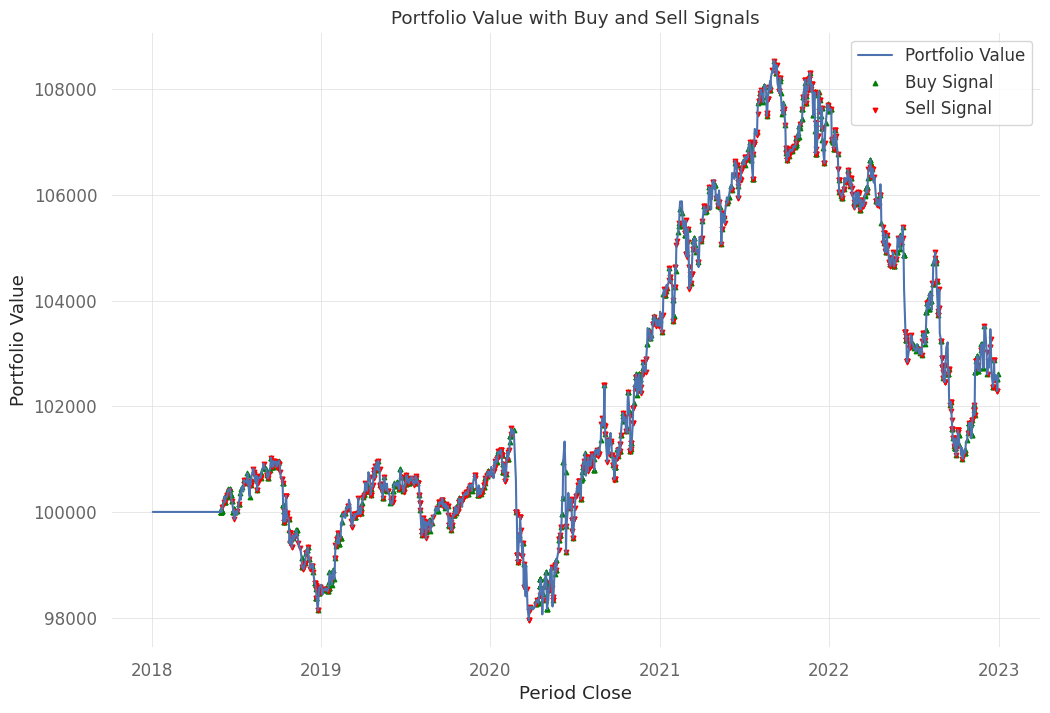

In [8]:
benchmark_returns = yf.download('^sp100', start=start_date, end=end_date, interval='1d')['Adj Close'].pct_change()
result.returns.index = benchmark_returns.index
result.index = benchmark_returns.index

qs.reports.full(result.returns, benchmark=benchmark_returns, df=result)